# Projet modèles à structures latentes

## Auto-encoder pour le clustering 

Auteurs : Mohamed BA, Abdoulaye KOROKO, Ramatoulaye NDIAYE

# SOMMAIRE
## I. GENERALITES ET PROBLEMATIQUE
## II. KMEANS POUR LE CLUSTERING D'IMAGES
## III. AUTO-ENCODER CLASSIQUES
## IV. AUTO-ENCODER VARIATIONNELS (VAEs)
## V. CONCLUSION

# I. Généralités et problématiques  
- Les algorithmes d'apprentissage profond(réseaux de neurones) sont bons pour effectuer des tâches utilisant des données étiquetées grâce à leurs capacités exceptionnelles à exprimer des représentations non linéaires. Ces types de tâches peuvent être la classification,la regression,etc. Cependant l'obtention des données étiquetées peut s'avérer chère voir impossible en fonction du domaine d'application (par exemple images infra-rouge dans le domaine médical).  
- Le clustering est l'une des techniques d'apprentissage automatique non supervisé ne nécessitant pas de données étiquetées. Il le fait en regroupant les ensembles de données par leurs similitudes.
- Nous nous intéressons au clustering d'images.L'algorithme populaire et efficace pour les problèmes d'apprentissage non supervisé est les K-moyennes(K-means). Cependant cet algorithme reste inefficace quand les données sont dans un espace à grande dimension (les images par exemple).
- Dans ce projet, nous utiliserons dans un premier temps les k-means pour le clustering d'images et dans un second temps utiliser les auto-encoders (explicités dans le rapport join) pour réaliser le clustering de ces images. Nous nous rendrons compte que cette dernière technique sera de loin** plus précise.

# II. K-means pour le clustering d'images
 Dans cette section nous utiliserons l'algorithme classique des k-means pour effectuer le clustering d'images. La base de donnée utilisée est une base composée des images en blanc-noir de taille 28 par 28 de chiffres manuscrits.  
 ### Chargement de la base de données

In [63]:
from keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()

### Visualisation du contenu des données

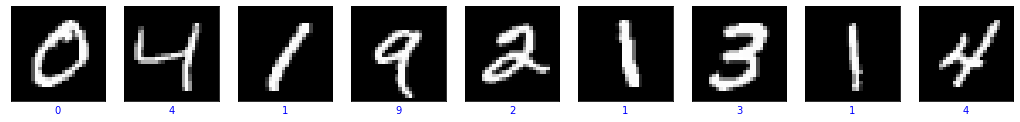

In [64]:
import matplotlib.pyplot as plt
n = 10
plt.figure(figsize=(20, 2))
for i in range(1,n):
    ax = plt.subplot(1, n, i)
    plt.imshow(x_train[i])
    plt.xlabel(str(y_train[i]),color="blue")
    plt.xticks([])
    plt.yticks([])
    plt.gray()
plt.show()

Nous prétraitons les données:
- Normalisation des valeurs
- Applatissement des données (transformer des matrices en vecteurs)

In [65]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print (x_test.shape)

(60000, 784)
(10000, 784)


A présent nous effectuons les k-means 

In [66]:
%%time
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score,confusion_matrix
n_clusters = len(np.unique(y_train)) # nombre de cluster
print("nombre de cluster: ",n_clusters)
kmeans = KMeans(n_clusters=n_clusters, n_init=20, n_jobs=4)
y_pred_kmeans = kmeans.fit_predict(x_train)

nombre de cluster:  10
Wall time: 3min 42s


In [67]:
print("précision des kmeans:",accuracy_score(y_train,y_pred_kmeans))
print("matrice de confusion:")
confusion_matrix(y_train,y_pred_kmeans)



précision des kmeans: 0.02495
matrice de confusion:


array([[ 182,   37,   14,   17,    3, 2496,  183, 2807,   21,  163],
       [   8,    6,    9,    9, 3717,    0,   10,    0, 2978,    5],
       [ 212,  173,   70, 4195,  365,   96,  156,   11,  352,  328],
       [  57,  176,   48,  218,  429,  126, 1027,   19,  104, 3927],
       [ 164, 3186, 1942,   38,  159,   11,   21,   10,  310,    1],
       [ 121,  375,  343,   15,  165,  251, 1506,   65,  800, 1780],
       [4912,   82,    1,   87,  272,  121,   92,  101,  222,   28],
       [   4, 1791, 3777,   39,  326,   14,   10,   15,  284,    5],
       [  47,  192,  179,   55,  298,   32, 3445,   38,  418, 1147],
       [   8, 2900, 2460,   12,  240,   19,   68,   38,  118,   86]],
      dtype=int64)

- Nous constatons une très mauvaise précision des kmeans pour la classification d'images. Cela s'explique par la dimension élevée des images ( ici 784).
- Dans les sections suivantes, nous essayerons d'améliorer largement cette précision à l'aide des auto-encoders

# III. Auto-encoders  
Comme expliqué dans le rapport join, le but principal des auto-encoders est la réduction de la dimension des données sans perdre d'information. En d'autres termes, c'est la compression de données et cela peut-être utile dans des situations nécessitant de faible dimension:
- visualisation de données
- stockage de données
- des programmes à forte complexité algorithmique  
La mise en place d'un auto-encoder s'effectue en deux étapes:
- Encodage: réduction de la dimension de la donnée d'entrée
- Décodage: reconstruction de la donnée codée qui dans le cas parfait est égale à la donnée initiale 
Le processus d'apprentissage est basé sur la recherche des paramètres qui minimise la distance euclidienne entre l'entrée $X$ et la valeur de sortie $X_{decoded}$.  

Dans ce projet, nous montrerons dans un premier temps à quoi ressemble une donnée (ici une image) après avoir subit les deux étapes et dans un second temps utiliser seulement la prémière étape (l'encodage pour réaliser le clustering).

In [68]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model

encoding_dim=2
input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)
#Créer l'auto-encoder
autoencoder = Model(input_img, decoded)
plot_model(autoencoder,to_file="autoencoder.png",show_shapes=True)

![Kitten](autoencoder.png "Fig 1") 

In [69]:
# Créer l'encoder
encoder = Model(input_img, encoded)
plot_model(encoder,to_file="encoder.png",show_shapes=True)


![Kitten](encoder.png "Fig 1") 

In [70]:
# Créer le décoder:
encoded_input = Input(shape=(128,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))
plot_model(decoder,to_file="decoder.png",show_shapes=True)

![Kitten](decoder.png "Fig 1") 

In [71]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 13s 212us/step - loss: 0.2868 - val_loss: 0.2533
Epoch 2/100
60000/60000 [==============================] - 9s 150us/step - loss: 0.2501 - val_loss: 0.2471
Epoch 3/100
60000/60000 [==============================] - 9s 153us/step - loss: 0.2426 - val_loss: 0.2375
Epoch 4/100
60000/60000 [==============================] - 10s 174us/step - loss: 0.2348 - val_loss: 0.2312
Epoch 5/100
60000/60000 [==============================] - 10s 173us/step - loss: 0.2302 - val_loss: 0.2283
Epoch 6/100
60000/60000 [==============================] - 9s 158us/step - loss: 0.2279 - val_loss: 0.2261
Epoch 7/100
60000/60000 [==============================] - 9s 152us/step - loss: 0.2259 - val_loss: 0.2241
Epoch 8/100
60000/60000 [==============================] - 9s 151us/step - loss: 0.2234 - val_loss: 0.2215
Epoch 9/100
60000/60000 [==============================] - 9s 153us/step - loss: 0.2208 - v

In [72]:
decoded_imgs=autoencoder.predict(x_test)

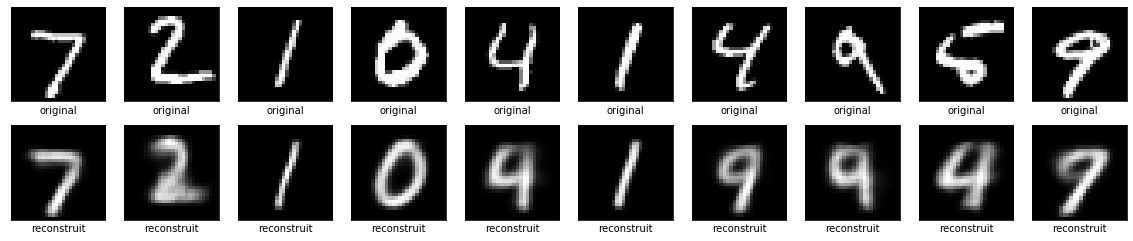

In [73]:
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    plt.xlabel("original")
    plt.xticks([])
    plt.yticks([])

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    plt.xlabel("reconstruit")
    plt.xticks([])
    plt.yticks([])
plt.show()

Nous voyons qu'à part un léger flou, les images originales sont égales aux images encodées et décodées.  A présent utilisons l'encodage pour réaliser notre clustering d'images

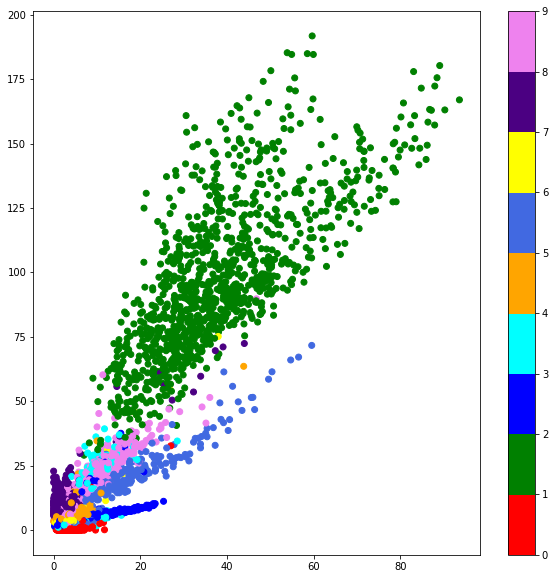

In [74]:
x_test_encoded = encoder.predict(x_test)
import matplotlib as mpl
#cmap = mpl.cm.cool
cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan','orange','royalblue','yellow',
                                  'indigo','violet'])
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
             cmap=cmap)
plt.colorbar()
plt.show()


- Sur le graphique, chaque couleur représente une classe de chiffre.  
- Comme nous pouvons le constater, les images sont bien groupées en fonction des chiffres qu'elles  contiennent.
- Les auto-encoders performent largement mieux que les K-means pour le clustering d'images.



# IV. Variational autoencoder (VAE)
- Les auto-encoders variationnels sont des auto-encoders classiques avec ajout de régularisation.
Cette régularisation se traduit par la modélisation de l'entrée comme une réalisation d'une variable aléatoire latente. L'étape d'encodage apprend à détecter la variable latente des entrées. Ainsi au lieu d'apprendre une représentation fonctionnelle des entrées, c'est plutôt les paramètres d'une distribution probabiliste qui sont appris par l'encoder. Généralement, on contraint cette distribution à être proche d'une loi normale centrée réduite. Ainsi la fonction objective (fonction optimisée pendant le processus d'apprentissage) est la somme de l'erreur de reconstruction et la divergence de Kullback-Leibler entre la loi latente estimée par l'encoder et la normale normale centrée réduite.  
Voir le rapport join pour plus de détails sur les VAEs
- Les VAEs peuvent être utilisés pour plusieurs applications:
   - la réduction de dimension et le clustering
   - la génération de nouvelles données: une fois, la variante latente des données entrées estimée par l'encoder, on peut généraliser de nouvelles données par tirage aléatoire selon cette variable latente.  
   
Dans cette section, nous utiliserons les VAEs pour le clustering et la génération de nouvelles images manuscrites

### Construction d'un VAE

In [87]:
original_dim=784
batch_size=256
intermediate_dim=50
latent_dim=2
x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [88]:
# Fonction de tirage aléatoire selon la variable latente
from keras.layers import Lambda
import keras.backend as K
epsilon_std=1
mean=0
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(latent_dim,),
                              mean=mean,stddev=epsilon_std)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_sigma])

In [89]:
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

In [90]:
# autoencoder
vae = Model(x, x_decoded_mean)

# encoder
encoder = Model(x, z_mean)

# generateur
decoder_input = Input(shape=(latent_dim,))
_h_decoded = decoder_h(decoder_input)
_x_decoded_mean = decoder_mean(_h_decoded)
generator = Model(decoder_input, _x_decoded_mean)

In [91]:
# Fonction objective = erreur de reconstruction + distance de Kullback-Leibler
from keras import objectives
def vae_loss(x, x_decoded_mean):
    xent_loss = objectives.binary_crossentropy(x, x_decoded_mean)
    kl_loss = - 0.5 * K.mean(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis=-1)
    return xent_loss + kl_loss

vae.compile(optimizer='adam', loss=vae_loss)
plot_model(vae,to_file="vae.png",show_shapes=True)


![Kitten](vae.png "Fig 1") 

In [92]:
#entrainement du réseau
vae.fit(x_train, x_train,
        shuffle=True,
        epochs=100,
        batch_size=batch_size,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 17s 277us/step - loss: 0.4911 - val_loss: 0.3177
Epoch 2/100
60000/60000 [==============================] - 9s 153us/step - loss: 0.2869 - val_loss: 0.2718
Epoch 3/100
60000/60000 [==============================] - 10s 159us/step - loss: 0.2692 - val_loss: 0.2670
Epoch 4/100
60000/60000 [==============================] - 9s 154us/step - loss: 0.2658 - val_loss: 0.2646
Epoch 5/100
60000/60000 [==============================] - 9s 154us/step - loss: 0.2646 - val_loss: 0.2641
Epoch 6/100
60000/60000 [==============================] - 10s 161us/step - loss: 0.2640 - val_loss: 0.2635
Epoch 7/100
60000/60000 [==============================] - 10s 162us/step - loss: 0.2637 - val_loss: 0.2633
Epoch 8/100
60000/60000 [==============================] - 10s 163us/step - loss: 0.2636 - val_loss: 0.2631
Epoch 9/100
60000/60000 [==============================] - 10s 164us/step - loss: 0.2633 

In [93]:
vae.load_weights("vae_weigths.h5") # chargement des meilleurs poids obtenus après entraitement sur GPU

On utilise l'encodage par le vae pour réaliser notre clustering d'images

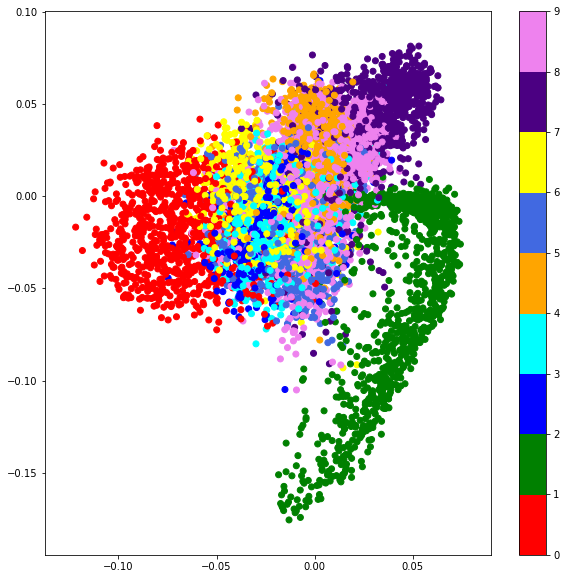

In [94]:
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
import matplotlib as mpl
cmap = mpl.colors.ListedColormap(['red', 'green', 'blue', 'cyan','orange','royalblue','yellow',
                                  'indigo','violet'])
plt.figure(figsize=(10, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,
             cmap=cmap)
plt.colorbar()
plt.show()


Nous pouvons constater que les images sont mieux séparées par rapport à l'utilisation d'un auto-encoder classique.

### Générations de nouvelles images

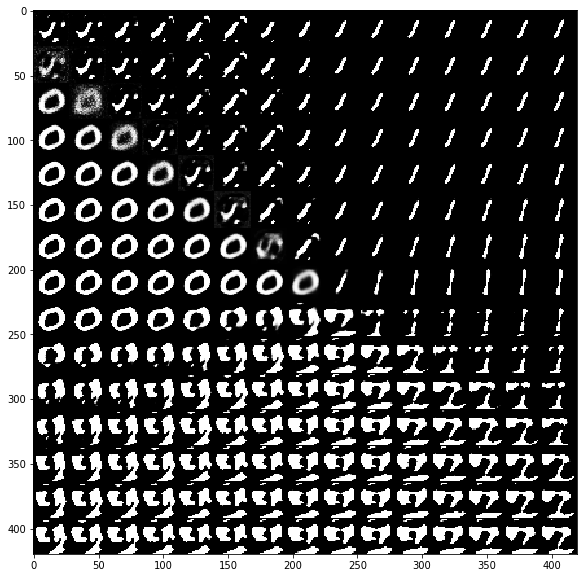

In [95]:
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]]) * epsilon_std
        x_decoded = generator.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Comme nous pouvons le constater de nouvelles images bruitées sont générées par les VAEs. Un bon choix des paramètres et un bon entraînement  permettrait d'avoir des images de meilleurs qualités.

# V. Conclusion  
Au terme de notre projet nous nous aperçevons que: 
- Les K-means sont très mauvais pour le clustering d'images.
- Les autoencoders permettent de bien compresser et décompresser les données et performent très bien pour le clustering d'images.
- Les VAEs permettent d'acquérir la structure latente des données d'entrée et donc mieux compresser-décompresser les données en diminuant le risque de sur-apprentissage par les autoencoders classiques.
- Qu'on peut généner de nouvelles données grâce aux VAEs en générant aléatoirement selon la variable latente estimée par le modèle.
 